In [ ]:
%tensorflow_version 2.x
import os
import numpy as np
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import time
import math

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

Found GPU at: /device:GPU:0


In [ ]:
# Data comes from:
# https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1626048000&interval=1d&events=history&includeAdjustedClose=true

csv_path = "https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1626048000&interval=1d&events=history&includeAdjustedClose=true"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [ ]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [ ]:
df.shape

(2491, 7)

Text(0, 0.5, 'Close Price (USD)')

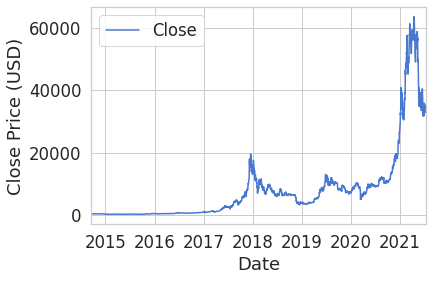

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

Text(0, 0.5, 'Close Price (USD)')

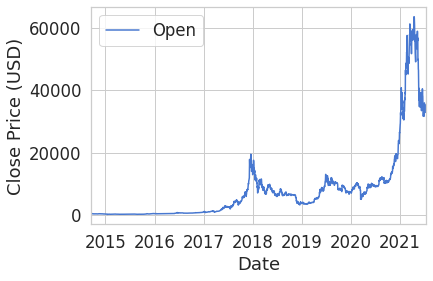

In [ ]:
ax = df.plot(x='Date', y='Open');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Data processing

In [ ]:
colnames = {
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Adj Close': 'adjClose',
    'Volume': 'volume'
}
df.rename(columns = colnames, inplace=True)
df.head()

,date,open,high,low,close,adjClose,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


# Feature construction

In [ ]:
df['dayVariation'] = df.apply(lambda row: row.close - row.open, axis=1)
df.head()

,date,open,high,low,close,adjClose,volume,dayVariation
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,-8.529999
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,-32.419983
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,-29.307007
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,14.230988
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,-9.263977


In [ ]:
df['upDown'] = df.apply(lambda row: row.dayVariation / abs(row.dayVariation), axis=1)
df.head()

,date,open,high,low,close,adjClose,volume,dayVariation,upDown
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,-8.529999,-1.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,-32.419983,-1.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,-29.307007,-1.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,14.230988,1.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,-9.263977,-1.0


In [ ]:
df.isna().sum()

date            0
open            4
high            4
low             4
close           4
adjClose        4
volume          4
dayVariation    4
upDown          4
dtype: int64

In [ ]:
df[df['open'].isnull()]


,date,open,high,low,close,adjClose,volume,dayVariation,upDown
2039,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2214,2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2217,2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2218,2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

date            0
open            0
high            0
low             0
close           0
adjClose        0
volume          0
dayVariation    0
upDown          0
dtype: int64

# Data analysis

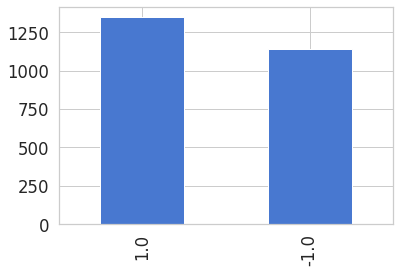

In [ ]:
df['upDown'].value_counts().plot(kind='bar')

# Close model

## Normalization

In [ ]:
close_scaler = MinMaxScaler()

close = df.close.values.reshape(-1, 1)

scaled_close = close_scaler.fit_transform(close)

In [ ]:
scaled_close

array([[0.00440947],
       [0.00389002],
       [0.0034219 ],
       ...,
       [0.52652554],
       [0.53789016],
       [0.52076684]])

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train.shape

(2267, 99, 1)

In [ ]:
X_test.shape

(120, 99, 1)

## Model

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

## Training

In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 10

start = time.time()
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

training_time = int(math.floor(time.time() - start))
print('Training time(s):', training_time)

Epoch 1/50
204/204 [==============================] - 44s 191ms/step - loss: 6.6474e-04 - val_loss: 0.0845
Epoch 2/50
204/204 [==============================] - 38s 185ms/step - loss: 0.0013 - val_loss: 0.0938
Epoch 3/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0012 - val_loss: 0.0942
Epoch 4/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0013 - val_loss: 0.0927
Epoch 5/50
204/204 [==============================] - 38s 187ms/step - loss: 0.0014 - val_loss: 0.0961
Epoch 6/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0017 - val_loss: 0.0959
Epoch 7/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0016 - val_loss: 0.0887
Epoch 8/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0014 - val_loss: 0.0836
Epoch 9/50
204/204 [==============================] - 38s 187ms/step - loss: 0.0014 - val_loss: 0.0678
Epoch 10/50
204/204 [==============================] - 38s 186ms/step

## Evaluation

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 108ms/step - loss: 0.2314


0.23142646253108978

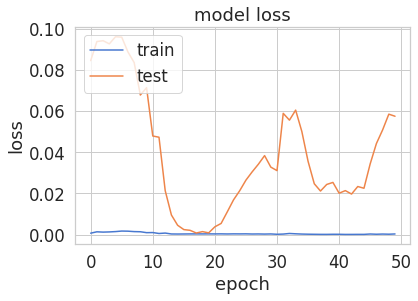

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

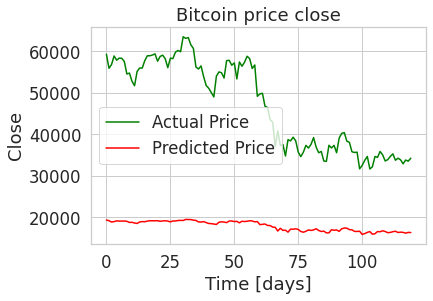

In [ ]:
y_close_predict = model.predict(X_test)

y_close_test_inverse = close_scaler.inverse_transform(y_test)
y_close_predict_inverse = close_scaler.inverse_transform(y_close_predict)
 
plt.plot(y_close_test_inverse, label="Actual Price", color='green')
plt.plot(y_close_predict_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price close')
plt.xlabel('Time [days]')
plt.ylabel('Close')
plt.legend(loc='best')
 
plt.show();

# Open model


## Normalization

In [ ]:
open_scaler = MinMaxScaler()

open = df.open.values.reshape(-1, 1)

scaled_open = open_scaler.fit_transform(open)

In [ ]:
scaled_open.shape

(2487, 1)

## Split

In [ ]:
X_open_train, y_open_train, X_open_test, y_open_test = preprocess(scaled_open, SEQ_LEN, train_split = 0.95)

In [ ]:
X_open_train.shape

(2267, 99, 1)

In [ ]:
X_open_test.shape

(120, 99, 1)

## Model

In [ ]:
DROPOUT_OPEN = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model_open = keras.Sequential()

model_open.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model_open.add(Dropout(rate=DROPOUT_OPEN))

model_open.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model_open.add(Dropout(rate=DROPOUT_OPEN))

model_open.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model_open.add(Dense(units=1))

model_open.add(Activation('linear'))

## Training

In [ ]:
model_open.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 10

start = time.time()
history_open = model_open.fit(
    X_open_train, 
    y_open_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

training_time = int(math.floor(time.time() - start))
print('Training time(s):', training_time)

Epoch 1/50
204/204 [==============================] - 43s 190ms/step - loss: 5.6464e-04 - val_loss: 0.0829
Epoch 2/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0014 - val_loss: 0.0961
Epoch 3/50
204/204 [==============================] - 38s 185ms/step - loss: 0.0012 - val_loss: 0.0927
Epoch 4/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0014 - val_loss: 0.0960
Epoch 5/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0014 - val_loss: 0.0954
Epoch 6/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0018 - val_loss: 0.0958
Epoch 7/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0016 - val_loss: 0.0851
Epoch 8/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0014 - val_loss: 0.0804
Epoch 9/50
204/204 [==============================] - 38s 186ms/step - loss: 0.0012 - val_loss: 0.0754
Epoch 10/50
204/204 [==============================] - 38s 186ms/step

In [ ]:
model_open.evaluate(X_open_test, y_open_test)

4/4 [==============================] - 0s 64ms/step - loss: 0.1425


0.14248687028884888

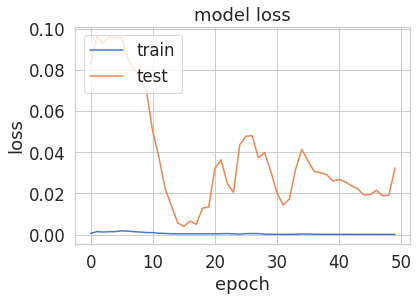

In [ ]:
plt.plot(history_open.history['loss'])
plt.plot(history_open.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

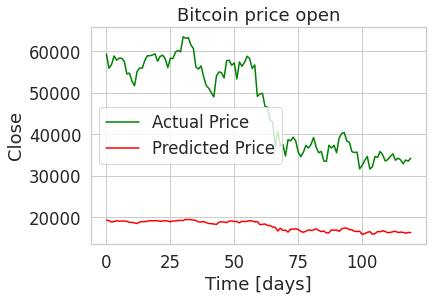

In [ ]:
y_open_predict = model.predict(X_test)

y_open_test_inverse = close_scaler.inverse_transform(y_test)
y_open_predict_inverse = close_scaler.inverse_transform(y_open_predict)
 
plt.plot(y_open_test_inverse, label="Actual Price", color='green')
plt.plot(y_open_predict_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price open')
plt.xlabel('Time [days]')
plt.ylabel('Close')
plt.legend(loc='best')
 
plt.show();

In [ ]:
test_df = pd.DataFrame(y_close_predict_inverse)
test_df.rename(columns={0: 'y_close_pred'}, inplace=True)
test_df.head()

,y_close_pred
0,19338.121094
1,19181.808594
2,18867.619141
3,18954.830078
4,19151.847656


In [ ]:
test_df['y_open_pred'] = y_open_predict_inverse
test_df['y_close'] = y_close_test_inverse
test_df['y_open'] = y_open_test_inverse
test_df.head()

,y_close_pred,y_open_pred,y_close,y_open
0,19338.121094,19338.121094,59302.316406,59302.316406
1,19181.808594,19181.808594,55907.199219,55907.199219
2,18867.619141,18867.619141,56804.902344,56804.902344
3,18954.830078,18954.830078,58870.894531,58870.894531
4,19151.847656,19151.847656,57858.921875,57858.921875


In [ ]:
#y_prediction = list(map(lambda x: int(x > 0)*2-1, y_hat_inverse))
#y_true = list(map(lambda x: x[0], y_test_inverse))
#y_true

In [ ]:
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
#
#cm = confusion_matrix(y_true, y_prediction)
#
#import seaborn as sn
#
#df_cm = pd.DataFrame(cm)
#sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

In [ ]:
#success = (cm[0, 0] + cm[1, 1]) / (cm[1,0] + cm[0, 1]) / 2 
#success